In [1]:
%matplotlib inline

import pandas as pd
import numpy as np

import sys
sys.path.append('modelflow/')

import modelclass as mc
import modelmanipulation as mp
import modeldiff as md


In [2]:
model      = '''
frml <> a = c(-1) + b $ 
frml <> d1 = x + 3 * e(-1)+ c **2 +a  $ 
frml <> d3 = x + 3 * a(-1)+c **3 $  
Frml <> x = 0.5 * c $'''
mmodel = mc.model(model,modelname = 'My first model')
df = pd.DataFrame({'B': [1,1,1,1],'C':[1,2,3,4],'E':[4,4,4,4]},index=[2018,2019,2020,2021])
base = mmodel(df)

Will start calculating: My first model
2019  solved
2020  solved
2021  solved
My first model calculated 


In [3]:
md.modeldiff(mmodel)

Now differentiating D3 0
Now differentiating D1 1
Now differentiating A 2
Now differentiating X 3
Find espressions for partial derivatives took       :         0.0239365101 Seconds
Model                           : My first model
Number of variables             : 7
Number of endogeneus variables  : 4
Number of derivatives           : 4


In [4]:
md.display_all(mmodel,base,2018)

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [5]:
matdir = md.calculate_allmat(mmodel,base,2018)

In [6]:
for l,m in matdir.items():
    print(f'Lag:{l} \n {m} \n')

for l,m in matdir.items():
    endomat = m.loc[:,[c for c in m.columns if c in mmodel.endogene]]
    print(f'Lag:{l} \n {endomat} \n')

Lag:0 
     A  D1  D3  X  B  C  E
A   0   0   0  0  0  0  0
D1  1   0   0  1  0  0  0
D3  0   0   0  1  0  0  0
X   0   0   0  0  0  0  0 

Lag:-1 
     A  D1  D3  X  B  C  E
A   0   0   0  0  0  0  0
D1  0   0   0  0  0  0  0
D3  3   0   0  0  0  0  0
X   0   0   0  0  0  0  0 

Lag:0 
     A  D1  D3  X
A   0   0   0  0
D1  1   0   0  1
D3  0   0   0  1
X   0   0   0  0 

Lag:-1 
     A  D1  D3  X
A   0   0   0  0
D1  0   0   0  0
D3  3   0   0  0
X   0   0   0  0 



In [7]:
fam   = '''
frml <> y = c+i $ 
frml <I> c = pa * y(-1) $
frml <> i = pc * (c-c(-1)) + im$'''

mma = mc.model(fam,modelname = 'Accelerator multiplicator model')
fhma = mp.find_hist_model(fam)  # Find the model to generate lagged values of c
mhma = mc.model(fhma)
years = 10
df = pd.DataFrame([[1000,200]]*years,index=range(2018,2018+years),columns=['Y','IM'])
df.loc[:,'PA'] = 0.9
df.loc[:,'PC'] = 0.9
start = mhma(df,silent=True)                         
base = mma(start,silent=True)

#md.modeldiff(mma)
#print(md.calculate_allmat(mma,base,2018))
md.get_compagnion(mma,mma.lastdf,2018)

,C(-1),I(-1),Y(-1)
C(-1),0.0,0.0,0.90
I(-1),-0.9,0.0,0.81
Y(-1),-0.9,0.0,1.71


In [8]:
def geteigen(mul,acc,years=100,show=False):
    '''Function which creates a Samuelson Multiplier accelerator model, runs it and 
    calculates the eigenvalues for the compaignion matrix in order to evaluate stability'''
    
    
    fam   = f'''
    frml <>  y = c+i $ 
    frml <I> c = {mul} * y(-1) $
    frml <>  i = {acc} * (c-c(-1)) + im $'''

    mma = mc.model(fam,modelname = 'Accelerator multiplicator model')

    df = pd.DataFrame([[1000,200]]*years,index=range(2018,2018+years),columns=['Y','IM'])

    start = mc.model(f'c = {mul} * y(-1)')(df,silent=True) # Generate lagged variables for c 
    base  = mma(start,silent=True)     # Solve the model 

    comp = md.get_compagnion(mma,mma.lastdf,2021) # get the compagnion matriox

    compeeig=np.linalg.eig(comp)       # find the eigenvalues 
    if show:
        _ = mma[['Y','C','i']].plot()  # Show the solution
        md.eigplot(compeeig[0])        # show the eigenvalues 
    return  

Stability   

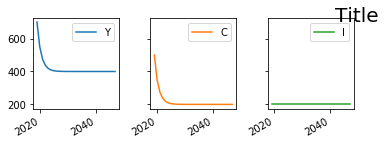

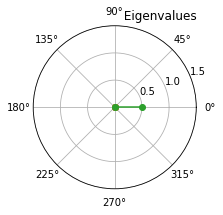

In [10]:
geteigen(mul=0.5,acc=0,years=30,show=1)

Explosion 

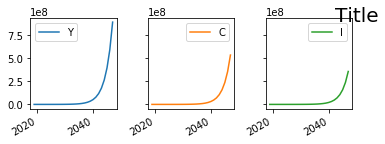

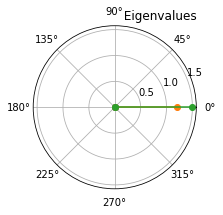

In [11]:
geteigen(mul=0.9,acc=2,years=30,show=1)

Exploding oscillations

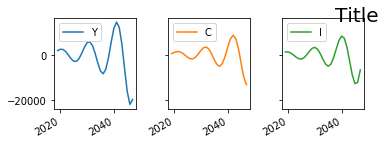

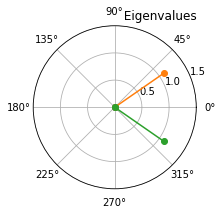

In [12]:
geteigen(mul=0.6,acc=2,years=30,show=1)

Perpetual oscillations 

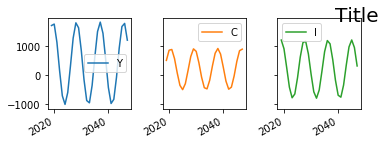

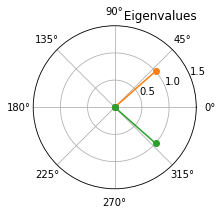

In [13]:
geteigen(mul=0.5,acc=2,years=30,show=1)

Dampened oscillations 

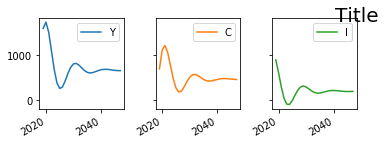

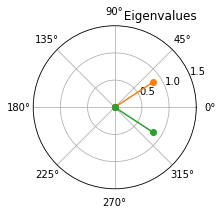

In [14]:
geteigen(mul=0.7,acc=1,years=30,show=1)